# Jupiter – Compact DM Conversion Notebook
A streamlined notebook mirroring the Earth analysis but using the jovian ionosphere and magnetic environment.

## Setup
Load shared modules and configure the plotting style used across the paper.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import LogLocator, LogFormatterSciNotation
import matplotlib.colors as mcolors
from scipy.interpolate import interp1d

from modules.planet_env import JUPITER_ENV
from modules.conversion import (
    plasma_freq,
    specific_brightness,
    spectral_flux_density,
    beam_filling_factor,
    resonance_radius,
)
from modules.noise import (
    ma_to_freq,
    freq_to_ma,
    galactic_background,
    brightness_qtn_jupiter,
    noise_rms,
)

plot_factor = 2
font_size = plot_factor * 9
lw_fixed = plot_factor * 1
column_width = plot_factor * 3.375
fig_width = column_width
fig_height = fig_width * 0.75

plt.rcParams.update({
    "text.usetex": True,
    "font.size": font_size,
    "axes.titlesize": font_size,
    "axes.labelsize": font_size,
    "xtick.labelsize": font_size,
    "ytick.labelsize": font_size,
    "legend.fontsize": font_size,
    "figure.titlesize": font_size,
    "font.family": "serif",
    "text.latex.preamble": r"\usepackage{amsmath}"
})

## Physical profiles
Density, magnetic field, and plasma frequency for Earth's ionosphere model.

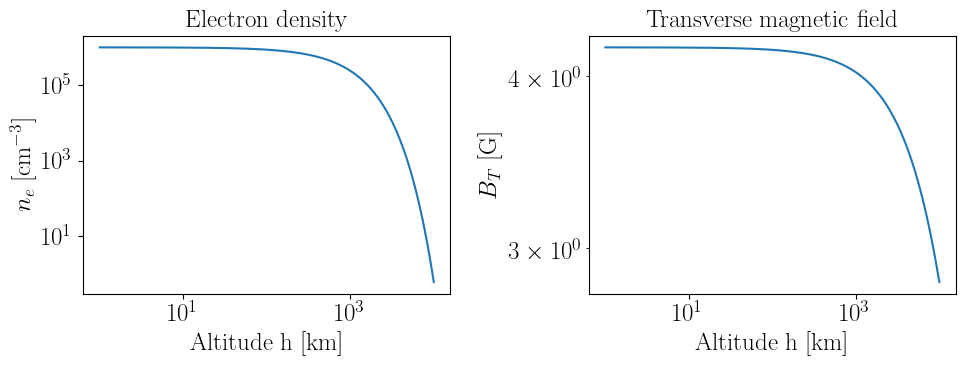

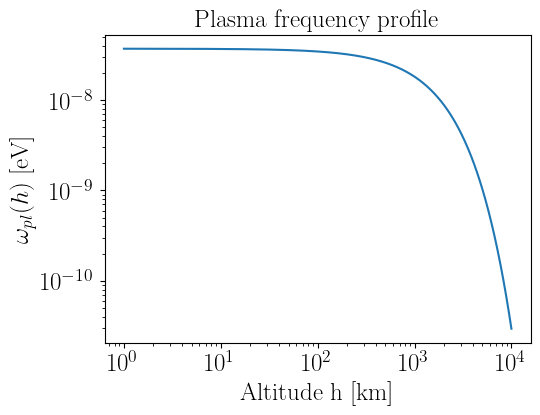

In [2]:
# Desnity and magnetic field profiles
h_km = np.logspace(0, 4, 800)
ne_cm3 = JUPITER_ENV.density_profile(h_km)
B_gauss = JUPITER_ENV.magnetic_profile(h_km)
omega_pl = plasma_freq(ne_cm3)

fig, ax = plt.subplots(1, 2, figsize=(10, 4))
ax[0].plot(h_km, ne_cm3)
ax[0].set_xscale('log')
ax[0].set_yscale('log')
ax[0].set_xlabel('Altitude h [km]')
ax[0].set_ylabel(r'$n_e$ [cm$^{-3}$]')
ax[0].set_title('Electron density')

ax[1].plot(h_km, B_gauss)
ax[1].set_xscale('log')
ax[1].set_yscale('log')
ax[1].set_xlabel('Altitude h [km]')
ax[1].set_ylabel(r'$B_T$ [G]')
ax[1].set_title('Transverse magnetic field')

fig.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(5.5, 4))
ax.plot(h_km, omega_pl)
ax.set_xscale('log')
ax.set_yscale('log')
ax.set_xlabel('Altitude h [km]')
ax.set_ylabel(r'$\omega_{pl}(h)$ [eV]')
ax.set_title('Plasma frequency profile')
plt.show()


In [3]:
ma_min = 1e-10 # eV, WKB validity constraint
ma_max = float(plasma_freq(1e6)) # eV, maximum plasma frequency

## Flux grids
Axion and dark-photon fluxes (bandwidth-averaged) evaluated on mass–coupling grids, with fixed distance and bandwidth. Then saved in .npz file

In [4]:
# Conversion probability grids
m_a_vals = np.logspace(-10, -5, 200)
g_vals = np.logspace(-15, -8, 200)
epsilon_vals = np.logspace(-18, -10, 200)

M, G = np.meshgrid(m_a_vals, g_vals)
M_eps, EPS = np.meshgrid(m_a_vals, epsilon_vals)


In [5]:
# Flux grids (axions and dark photons)
bandwidth_hz = 1e3
D_4AU_m = 4.0 * 1.496e11

F_axion = spectral_flux_density(
    JUPITER_ENV,
    M,
    G,
    distance_m=D_4AU_m,
    bandwidth_Hz=bandwidth_hz,
    species='axion'
)
F_dp = spectral_flux_density(
    JUPITER_ENV,
    M_eps,
    EPS,
    distance_m=D_4AU_m,
    bandwidth_Hz=bandwidth_hz,
    species='dp'
)

rc_vals = resonance_radius(JUPITER_ENV, m_a_vals) * 1e3
np.savez(
    'grids/flux_grids_jupiter_compact.npz',
    m_a_vals=m_a_vals,
    g_vals=g_vals,
    epsilon_vals=epsilon_vals,
    F_axion=F_axion,
    F_dp=F_dp,
    rc_vals=rc_vals,
    distance_m=D_4AU_m,
    bandwidth_hz=bandwidth_hz
)
print('Saved flux grids to grids/flux_grids_jupiter_compact.npz')


Saved flux grids to grids/flux_grids_jupiter_compact.npz


## Flux vs. distance
Normalized flux for fixed couplings as a function of observer distance.

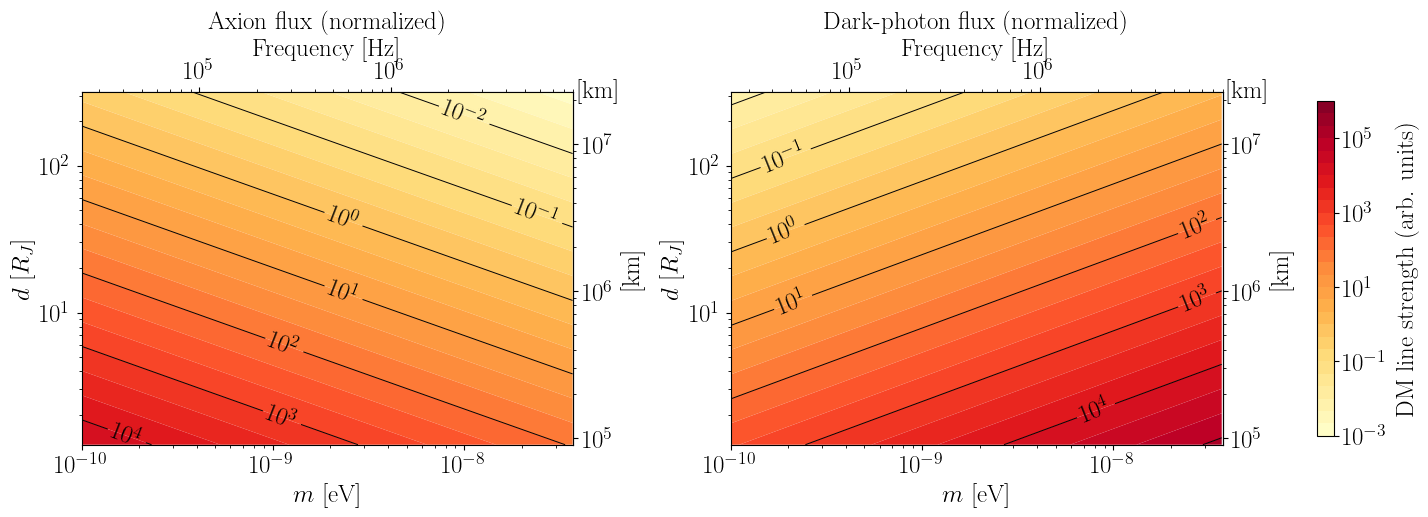

In [6]:
R_J_m = JUPITER_ENV.radius_m
g_fixed = 1e-13  # GeV^-1
eps_fixed = 1e-14
bandwidth_line = 1.0  # Hz

d_vals = np.logspace(0.1, 2.5, 200) * R_J_m
m_a_vals_d = np.logspace(np.log10(ma_min*1.01), np.log10(ma_max*0.99), 200)
M_d, D = np.meshgrid(m_a_vals_d, d_vals)

def Rj_to_km(rj):
    return rj * JUPITER_ENV.radius_km

def km_to_Rj(km):
    return km / JUPITER_ENV.radius_km

def decade_label_jy(v):
    n = int(np.round(np.log10(v)))
    return rf"$10^{{{n}}}$"

F_ax_line = spectral_flux_density(JUPITER_ENV, M_d, np.full_like(M_d, g_fixed), distance_m=D, bandwidth_Hz=bandwidth_line, species='axion')
F_dp_line = spectral_flux_density(JUPITER_ENV, M_d, np.full_like(M_d, eps_fixed), distance_m=D, bandwidth_Hz=bandwidth_line, species='dp')

F_ref = 1e-24
F_ax_norm = np.where(F_ax_line > 0, F_ax_line / F_ref, np.nan)
F_dp_norm = np.where(F_dp_line > 0, F_dp_line / F_ref, np.nan)

finite_ax = np.isfinite(F_ax_norm) & (F_ax_norm > 0)
finite_dp = np.isfinite(F_dp_norm) & (F_dp_norm > 0)
common_min = np.nanmin([np.nanmin(F_ax_norm[finite_ax]), np.nanmin(F_dp_norm[finite_dp])])
common_max = np.nanmax([np.nanmax(F_ax_norm[finite_ax]), np.nanmax(F_dp_norm[finite_dp])])
vmin = 10 ** np.floor(np.log10(common_min))
vmax = 10 ** np.ceil(np.log10(common_max))

def filled_contour_with_decades(ax, X, Y, Z, vmin, vmax, cmap='YlOrRd', nlevels=3 * (int(np.log10(vmax/vmin)) + 1) - 2, title=None):
    finite = np.isfinite(Z) & (Z > 0)
    if not np.any(finite):
        raise ValueError("No valid values for contour.")

    levels_filled = np.logspace(np.log10(vmin), np.log10(vmax), nlevels)
    cf = ax.contourf(
        X, Y, Z,
        levels=levels_filled,
        norm=LogNorm(vmin=vmin, vmax=vmax),
        cmap=cmap,
        antialiased=True,
    )

    mask_valid = np.isfinite(Z) & (Z > 0)
    ax.contour(X, Y, mask_valid, levels=[0.5], colors='k', linestyles='-', linewidths=0.7, zorder=6)
    ax.contourf(X, Y, (~mask_valid).astype(int), levels=[0.5, 1.5], colors='white', alpha=0.5, zorder=4)
    with plt.rc_context({'hatch.color': 'lightgray', 'hatch.linewidth': 0.5}):
        ax.contourf(
            X, Y, (~mask_valid).astype(int),
            levels=[0.5, 1.5], colors='none', hatches=['///'], zorder=5,
        )

    n_lo = int(np.floor(np.log10(vmin)))
    n_hi = int(np.ceil(np.log10(vmax)))
    levels_lines = 10.0 ** np.arange(n_lo, n_hi + 1)
    cs = ax.contour(X, Y, Z, levels=levels_lines, colors='k', linewidths=0.7)
    ax.clabel(cs, fmt=decade_label_jy, inline=True, fontsize=font_size)

    if title:
        ax.set_title(title)
    return cf


fig, axes = plt.subplots(1, 2, figsize=(2.1 * fig_width, fig_height), constrained_layout=True)

axes[0].set_xscale('log'); axes[0].set_yscale('log')
axes[0].set_xlim(ma_min, ma_max)
axes[0].set_xlabel(r'$m$ [eV]'); axes[0].set_ylabel(r'$d$ [$R_J$]')
cf0 = filled_contour_with_decades(axes[0], M_d, D / R_J_m, F_ax_norm, vmin, vmax, cmap='YlOrRd', title='Axion flux (normalized)')
secax0 = axes[0].secondary_xaxis('top', functions=(ma_to_freq, freq_to_ma))
secax0.set_xlabel('Frequency [Hz]'); secax0.set_xscale('log')
secax0.xaxis.set_major_locator(LogLocator(base=10.0))
secax0.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=12))
secax0.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
secay0 = axes[0].secondary_yaxis('right', functions=(Rj_to_km, km_to_Rj))
secay0.set_ylabel('[km]')

axes[1].set_xscale('log'); axes[1].set_yscale('log')
axes[1].set_xlim(ma_min, ma_max)
axes[1].set_xlabel(r'$m$ [eV]'); axes[1].set_ylabel(r'$d$ [$R_J$]')
cf1 = filled_contour_with_decades(axes[1], M_d, D / R_J_m, F_dp_norm, vmin, vmax, cmap='YlOrRd', title='Dark-photon flux (normalized)')
secax1 = axes[1].secondary_xaxis('top', functions=(ma_to_freq, freq_to_ma))
secax1.set_xlabel('Frequency [Hz]'); secax1.set_xscale('log')
secax1.xaxis.set_major_locator(LogLocator(base=10.0))
secax1.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=12))
secax1.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
secay1 = axes[1].secondary_yaxis('right', functions=(Rj_to_km, km_to_Rj))
secay1.set_ylabel('[km]')

for ax in axes:
    ax.grid(True, which='both', ls=':', alpha=0)
    ax.text(1.01, 0.97, '[km]', transform=ax.transAxes, ha='left', va='bottom')

cbar = fig.colorbar(cf1, ax=axes.ravel().tolist(), shrink=0.95, pad=0.02)
cbar.set_label(r'DM line strength (arb. units)')
cbar.locator = LogLocator(base=10)
cbar.update_ticks()

plt.show()


## Noise model
Combine Galactic background and QTN at 5 AU, then compute RMS.

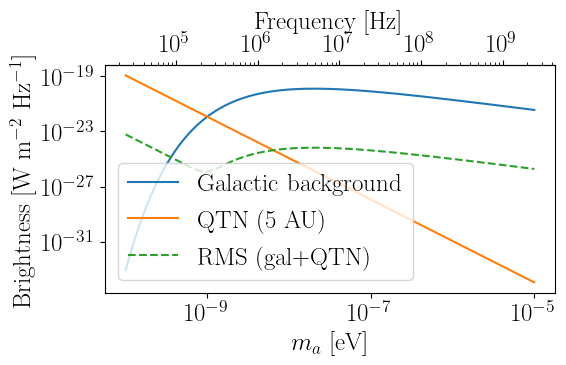

In [7]:
# Galactic + QTN noise model
bandwidth_noise = 1e3  # Hz
integration_hours = 100

gal_brightness = galactic_background(m_a_vals)
qtn_brightness = brightness_qtn_jupiter(m_a_vals)
noise_total = gal_brightness + qtn_brightness
rms_noise = noise_rms(noise_total, bandwidth_noise, integration_hours)

fig, ax = plt.subplots(figsize=(6, 4))
ax.plot(m_a_vals, gal_brightness, label='Galactic background')
ax.plot(m_a_vals, qtn_brightness, label='QTN (5 AU)')
ax.plot(m_a_vals, rms_noise, label='RMS (gal+QTN)', linestyle='--')
ax.set_xscale('log'); ax.set_yscale('log')
ax.set_xlabel(r'$m_a$ [eV]')
ax.set_ylabel(r'Brightness [W m$^{-2}$ Hz$^{-1}$]')
ax.legend()
secax = ax.secondary_xaxis('top', functions=(ma_to_freq, freq_to_ma))
secax.set_xlabel('Frequency [Hz]')
secax.set_xscale('log')
secax.xaxis.set_major_locator(LogLocator(base=10.0))
secax.xaxis.set_minor_locator(LogLocator(base=10.0, subs='auto', numticks=12))
secax.xaxis.set_major_formatter(LogFormatterSciNotation(labelOnlyBase=False))
plt.tight_layout()
plt.show()


## Sensitivity curves
Distance-dependent sensitivity derived from the noise model and beam filling.

/var/folders/b2/zlyly22j38b0wyqkfr88r3hc0000gq/T/ipykernel_16731/3573063871.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = plt.cm.get_cmap('plasma', len(distances_RJ))


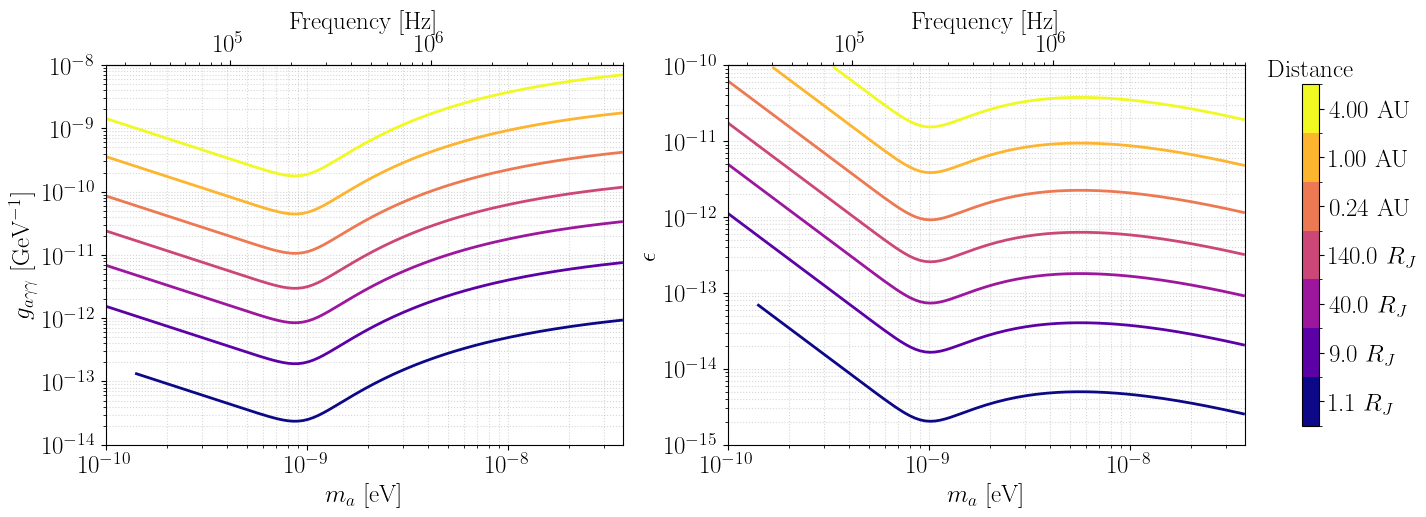

In [8]:
# Sensitivity curves vs distance
SNR = 2
n_pol = 1  # implicit in noise_rms expression

B_ax = specific_brightness(JUPITER_ENV, M, G, bandwidth_noise, species='axion')
B_dp = specific_brightness(JUPITER_ENV, M_eps, EPS, bandwidth_noise, species='dp')

distances_RJ = [1.11, 9, 40, 140, 500, D_4AU_m / JUPITER_ENV.radius_m / 4, D_4AU_m / JUPITER_ENV.radius_m]
cmap = plt.cm.get_cmap('plasma', len(distances_RJ))
colors = cmap(np.linspace(0, 1, len(distances_RJ)))
norm = mcolors.BoundaryNorm(range(len(distances_RJ) + 1), cmap.N)

fig, axes = plt.subplots(1, 2, figsize=(2.1 * fig_width, fig_height), constrained_layout=True)

for i, d_RJ in enumerate(distances_RJ):
    d_m = d_RJ * JUPITER_ENV.radius_m
    phi = beam_filling_factor(JUPITER_ENV, m_a_vals, d_m, invalid='nan')
    target = SNR * rms_noise

    g_curve = []
    for j in range(len(m_a_vals)):
        if not np.isfinite(phi[j]) or phi[j] <= 0:
            g_curve.append(np.nan)
            continue
        sig_col = B_ax[:, j] * phi[j]
        mask = np.isfinite(sig_col) & (sig_col > 0)
        if mask.sum() < 2:
            g_curve.append(np.nan)
            continue
        interp = interp1d(
            np.log10(sig_col[mask]),
            np.log10(g_vals[mask]),
            bounds_error=False,
            fill_value=np.nan,
        )
        tgt = target[j]
        if not np.isfinite(tgt) or tgt <= 0:
            g_curve.append(np.nan)
            continue
        g_curve.append(10 ** interp(np.log10(tgt)))
    g_curve = np.array(g_curve)
    axes[0].plot(m_a_vals, g_curve, color=colors[i], lw=lw_fixed)

    eps_curve = []
    for j in range(len(m_a_vals)):
        if not np.isfinite(phi[j]) or phi[j] <= 0:
            eps_curve.append(np.nan)
            continue
        sig_col = B_dp[:, j] * phi[j]
        mask = np.isfinite(sig_col) & (sig_col > 0)
        if mask.sum() < 2:
            eps_curve.append(np.nan)
            continue
        interp = interp1d(
            np.log10(sig_col[mask]),
            np.log10(epsilon_vals[mask]),
            bounds_error=False,
            fill_value=np.nan,
        )
        tgt = target[j]
        if not np.isfinite(tgt) or tgt <= 0:
            eps_curve.append(np.nan)
            continue
        eps_curve.append(10 ** interp(np.log10(tgt)))
    eps_curve = np.array(eps_curve)
    axes[1].plot(m_a_vals, eps_curve, color=colors[i], lw=lw_fixed)

for ax, ylabel, title in zip(
    axes,
    [r'$g_{a\gamma\gamma}$ [GeV$^{-1}$]', r'$\epsilon$'],
    ['Axion sensitivity', 'Dark-photon sensitivity']
):
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$m_a$ [eV]')
    ax.set_ylabel(ylabel)
    ax.set_xlim(1e-10, plasma_freq(1e6))
    ax.grid(True, which='both', ls=':', alpha=0.5)

    secax = ax.secondary_xaxis('top', functions=(ma_to_freq, freq_to_ma))
    secax.set_xlabel("Frequency [Hz]")

axes[0].set_ylim(1e-14, 1e-8)
axes[1].set_ylim(1e-15, 1e-10)

# Y-axis locator improvement
for ax in axes:
    ax.yaxis.set_major_locator(LogLocator(base=10.0, numticks=20))
    ax.yaxis.set_minor_locator(LogLocator(base=10.0, subs=np.arange(2, 10) * 0.1, numticks=20))

# Distance colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
cbar = fig.colorbar(
    sm,
    ax=axes.ravel().tolist(),
    ticks=np.arange(len(distances_RJ)) + 0.5,
    location='right',
    shrink=0.9,
)
labels = []
for d in distances_RJ:
    if d < 150:
        labels.append(fr"{d:.1f} $R_J$")
    else:
        labels.append(fr"{d * JUPITER_ENV.radius_m / 1.496e11:.2f} AU")
cbar.ax.set_yticklabels(labels)
cbar.ax.set_title('Distance', pad=6)

plt.show()
